<a href="https://colab.research.google.com/github/jenny005/Reinforcement-Learning-by-Sutton-Barto/blob/main/Chapter_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example 8.1: Dyna Maze

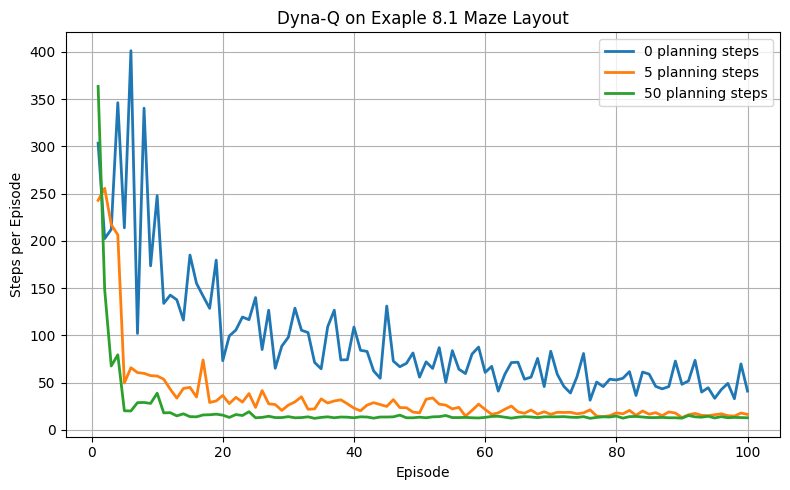

In [3]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Maze Environment for Dyna-Q (from your image) ---
class MazeEnv:
    def __init__(self):
        # 0 = free cell, 1 = wall
        # 7 rows × 10 columns, row 0 is top.
        self.grid = np.array([
            [0,0,0,0,0,0,0,0,0,0],  # row 0
            [0,0,0,0,0,0,0,1,1,0],  # the two‐wide vertical wall just left of G
            [0,1,1,0,0,0,0,1,1,0],  # the two‐wide vertical wall left of S
            [0,1,1,0,0,0,0,0,0,0],
            [0,0,0,0,1,1,1,0,0,0],  # the horizontal three‐wide wall near the bottom
            [0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0],
        ])
        self.start = (2, 0)   # row 2, col 0 (“S”)
        self.goal  = (1, 9)   # row 1, col 9 (“G”)
        self.reset()

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        """
        action: 0=up, 1=right, 2=down, 3=left
        returns: next_state, reward, done, {}
        """
        moves = [(-1,0), (0,1), (1,0), (0,-1)]
        dr, dc = moves[action]
        r, c = self.agent_pos
        r2, c2 = r + dr, c + dc
        # only move if inside grid and not into a wall
        if 0 <= r2 < self.grid.shape[0] and 0 <= c2 < self.grid.shape[1] and self.grid[r2,c2] == 0:
            self.agent_pos = (r2, c2)

        # reward & termination
        if self.agent_pos == self.goal:
            return self.agent_pos, 0, True, {}
        else:
            return self.agent_pos, -1, False, {}

# --- ε‐Greedy Policy ---
def epsilon_greedy(Q, state, n_actions, epsilon):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    vals = Q[state]
    max_val = np.max(vals)
    # break ties uniformly
    best = [a for a,v in enumerate(vals) if v==max_val]
    return random.choice(best)

# --- Dyna-Q Algorithm ---
def dyna_q(env, planning_steps=10, episodes=100, alpha=0.1, gamma=0.95, epsilon=0.1):
    # Initialize Q(s,a) = 0
    Q = { (r,c): np.zeros(4)
          for r in range(env.grid.shape[0])
          for c in range(env.grid.shape[1]) }
    # Model: maps (s,a)->(r,s')
    model = {}
    seen = []   # list of (s,a) experienced
    steps_per_episode = []

    for ep in range(episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, 4, epsilon)
        steps = 0
        done = False

        while not done:
            next_state, reward, done, _ = env.step(action)

            # 1) Real Q-learning update
            td_target = reward + gamma * np.max(Q[next_state])
            Q[state][action] += alpha * (td_target - Q[state][action])

            # 2) Update model
            model[(state, action)] = (reward, next_state)
            if (state, action) not in seen:
                seen.append((state, action))

            # 3) Planning updates
            for _ in range(planning_steps):
                s_p, a_p = random.choice(seen)
                r_p, s_next_p = model[(s_p, a_p)]
                td_targ_p = r_p + gamma * np.max(Q[s_next_p])
                Q[s_p][a_p] += alpha * (td_targ_p - Q[s_p][a_p])

            # 4) Move to next real state
            state = next_state
            action = epsilon_greedy(Q, state, 4, epsilon)
            steps += 1

        steps_per_episode.append(steps)

    return steps_per_episode

# --- Main & Plotting ---
if __name__ == "__main__":
    env = MazeEnv()
    episodes = 100
    runs = 5
    planning_steps_list = [0, 5, 50]

    avg = {}
    for p in planning_steps_list:
        all_runs = [dyna_q(env, p, episodes) for _ in range(runs)]
        avg[p] = np.mean(all_runs, axis=0)

    plt.figure(figsize=(8,5))
    for p, steps in avg.items():
        plt.plot(range(1, episodes+1), steps, lw=2, label=f"{p} planning steps")
    plt.xlabel("Episode")
    plt.ylabel("Steps per Episode")
    plt.title("Dyna-Q on Exaple 8.1 Maze Layout")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
